# Decision Trees for Regression

In this Jupyter notebook we're going to use Regression Trees on our boston dataset

| Model Name  | MAE  |
|---|---|
| Linear Regression  | 4517 |
| SVR(kernel='linear') | 4247  |
| SVR(kernel='rbf') | 3103  |

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
boston = load_boston()
boston_df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
X = boston_df[['RM', 'LSTAT', 'NOX']]
y = boston['target']

## Split test data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

regressor = DecisionTreeRegressor().fit(X_train, y_train)

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

training_mse = mean_squared_error(y_train, regressor.predict(X_train))
training_mae = mean_absolute_error(y_train, regressor.predict(X_train))
print("Training set MSE: {:.3f}".format(training_mse))
print("Training set MAE: {:.2f}".format(training_mae*1000))

Training set MSE: 0.000
Training set MAE: 0.00


In [4]:
test_mse = mean_squared_error(y_test, regressor.predict(X_test))
test_mae = mean_absolute_error(y_test, regressor.predict(X_test))
print("Test set MSE: {:.3f}".format(test_mse))
print("Test set MAE: {:.2f}".format(test_mae*1000))

Test set MSE: 22.938
Test set MAE: 2883.33


In [5]:
regressor.tree_.node_count

779

In [6]:
X.columns.values

array(['RM', 'LSTAT', 'NOX'], dtype=object)

### Visualise

In [7]:
## you'll have to install this library. Note: graphiz
import graphviz 
from sklearn.tree import export_graphviz

dot_data = export_graphviz(regressor, feature_names=X.columns.values, filled=True, 
                                rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)
#graph
graph.render("decision-tree")

'decision-tree.pdf'

## Some Techniques for Preventing Overfitting

* max_depth
* min_samples_leaf
* min_impurity_decrease
* ccp_alpha

### max_depth

In [8]:
def print_model_scores(regressor, training_data, test_data):
    
    X_train, y_train = training_data
    X_test, y_test = test_data
    
    training_mse = mean_squared_error(y_train, regressor.predict(X_train))
    training_mae = mean_absolute_error(y_train, regressor.predict(X_train))

    test_mse = mean_squared_error(y_test, regressor.predict(X_test))
    test_mae = mean_absolute_error(y_test, regressor.predict(X_test))

    print("Training set MSE: {:.3f}".format(training_mse))
    print("Training set MAE: {:.2f}".format(training_mae*1000))
    print("Test set MSE: {:.3f}".format(test_mse))
    print("Test set MAE: {:.2f}".format(test_mae*1000))
    print()
    print("Number of nodes:", regressor.tree_.node_count)

In [9]:
regressor = DecisionTreeRegressor(max_depth=5).fit(X_train, y_train)

In [10]:
print_model_scores(regressor, (X_train, y_train), (X_test, y_test))

Training set MSE: 9.090
Training set MAE: 2084.32
Test set MSE: 18.480
Test set MAE: 2677.12

Number of nodes: 51


### min_samples_leaf

In [11]:
regressor = DecisionTreeRegressor(min_samples_leaf=5).fit(X_train, y_train)
print_model_scores(regressor, (X_train, y_train), (X_test, y_test))

Training set MSE: 9.966
Training set MAE: 1993.45
Test set MSE: 15.096
Test set MAE: 2734.49

Number of nodes: 127


### min_impurity_decrease

In [12]:
regressor = DecisionTreeRegressor(min_impurity_decrease=0.2).fit(X_train, y_train)
print_model_scores(regressor, (X_train, y_train), (X_test, y_test))

Training set MSE: 6.642
Training set MAE: 1986.96
Test set MSE: 18.818
Test set MAE: 2621.40

Number of nodes: 53


### Pruning

Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed.

In [13]:
regressor = DecisionTreeRegressor(random_state=0)
path = regressor.cost_complexity_pruning_path(X, y)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

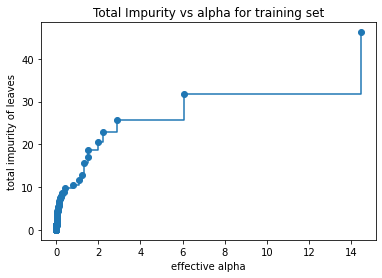

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs alpha for training set")
plt.show()

In [15]:
from sklearn.model_selection import GridSearchCV
grid = {
    'ccp_alpha': ccp_alphas
}
grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=0), grid, scoring='neg_mean_squared_error', cv=5)

In [16]:
_ = grid_dt.fit(X, y)

In [17]:
grid_dt.best_params_

{'ccp_alpha': 0.38794654620740254}

In [18]:
regressor = DecisionTreeRegressor(ccp_alpha=0.3879465462074229).fit(X_train, y_train)
print_model_scores(regressor, (X_train, y_train), (X_test, y_test))

Training set MSE: 9.217
Training set MAE: 2338.28
Test set MSE: 23.959
Test set MAE: 2864.96

Number of nodes: 35


### cross_validated score

In [19]:
from sklearn.model_selection import cross_val_score
mae_dt = cross_val_score(DecisionTreeRegressor(ccp_alpha=0.3879465462074229), X, y, cv=5, scoring='neg_mean_absolute_error')
print("MAE : {:.2f}".format(np.abs(np.mean(mae_dt))*1000))

MAE : 3482.34
